In [2]:
# 데이터 셋 기본 정보 구하기
%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rating_file_path = "C:/Users/yejin/Downloads/ml-latest-small/ml-latest-small/ratings.csv"
movie_file_path = "C:/Users/yejin/Downloads/ml-latest-small/ml-latest-small/movies.csv"

rating_data = pd.io.parsers.read_csv(rating_file_path, delimiter=',', engine='python')
movie_data = pd.io.parsers.read_csv(movie_file_path, delimiter=',', engine='python')

print(rating_data.head())
print(movie_data.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [3]:
# EDA
# 분석할 영화 정보 탐색 과정
# 연도별 영화 개수가 많은 TOP 10 연도 출력
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

year
2002    311
2006    295
2001    294
2000    283
2007    283
2009    282
2003    279
2004    279
2014    277
1996    276
Name: count, dtype: int64

C:\Users\yejin\AppData\Local\Temp\ipykernel_11456\2908991371.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(unique_genre_dict.keys()), y=list(unique_genre_dict.values()), palette="husl", alpha=0.8)


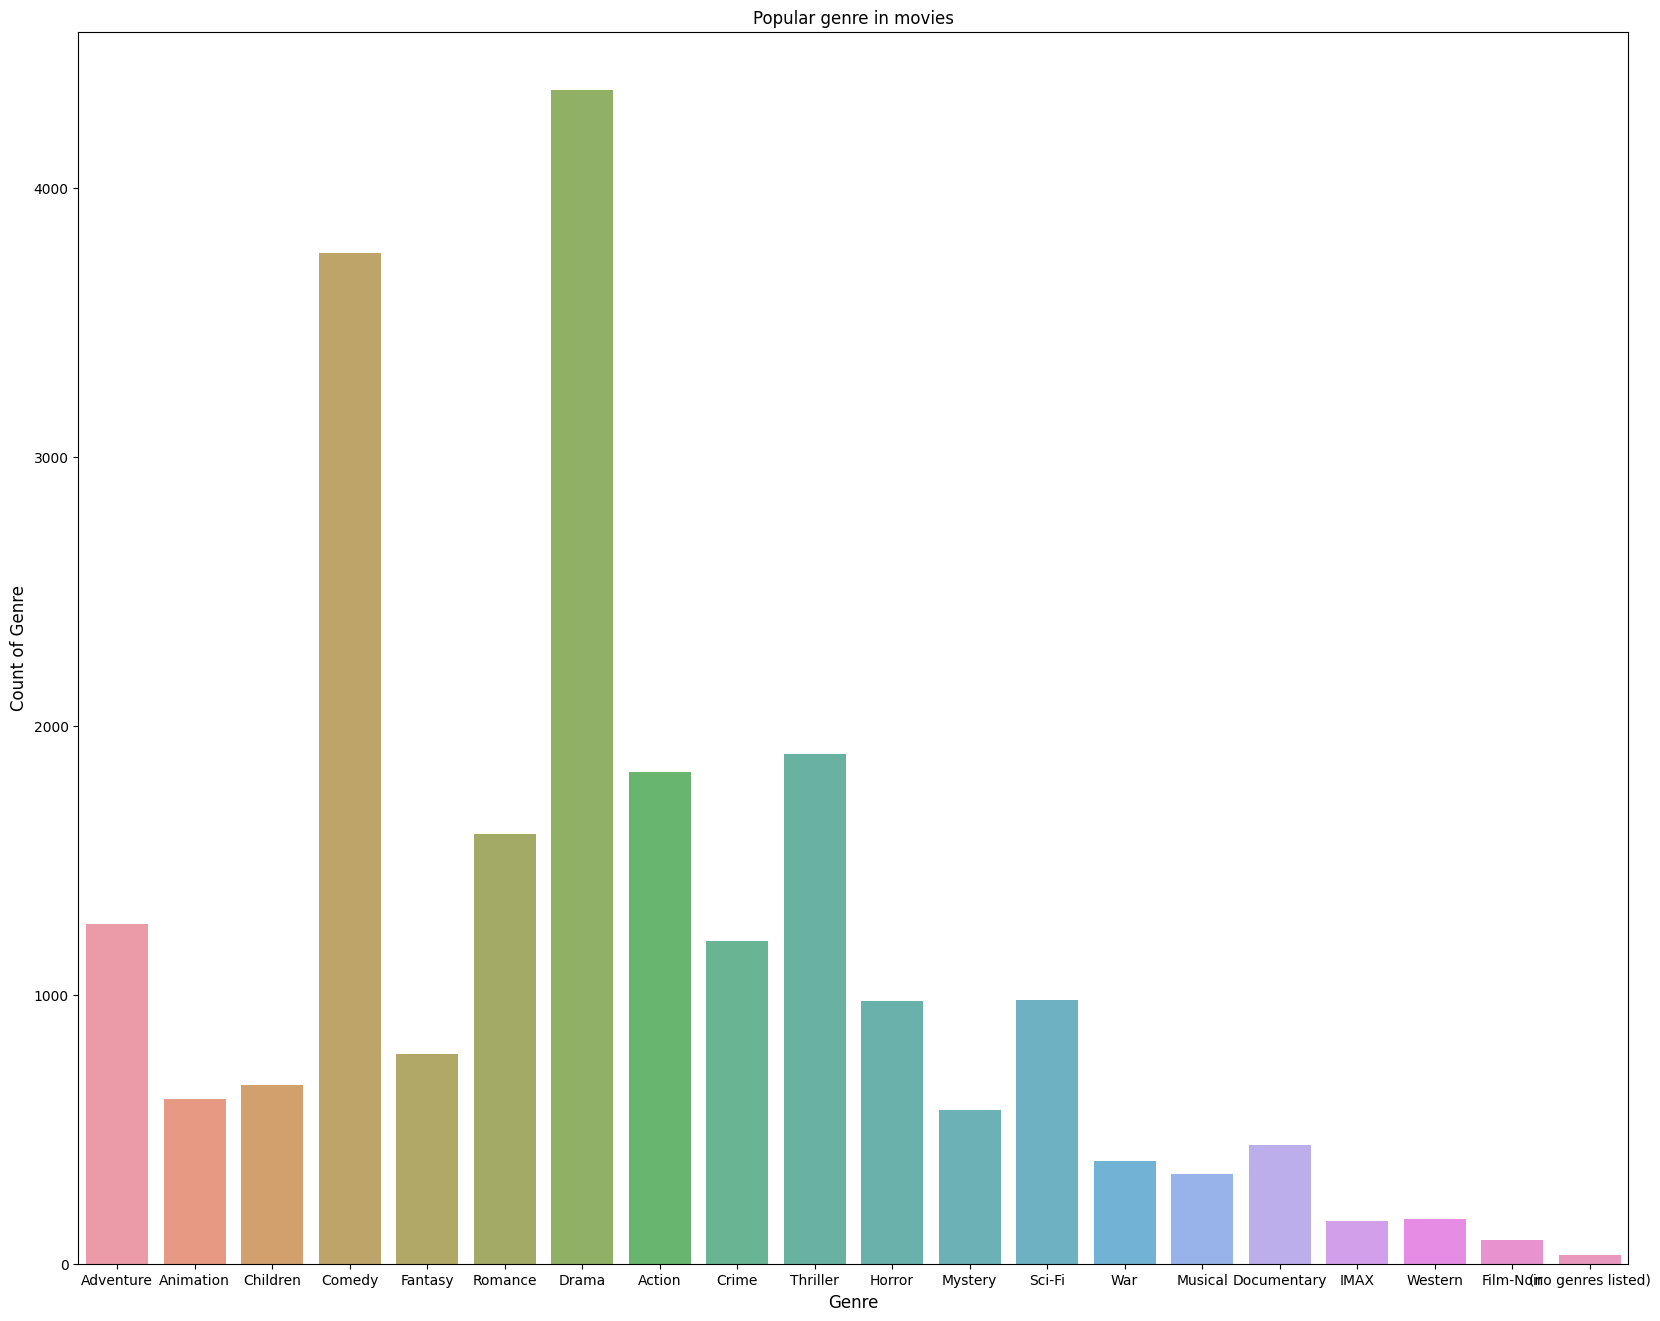

In [4]:
# 장르 속성 탐색
# 가장 많이 등장한 장르 속성 추출
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    genre_combination = row['genres'] # genre 피쳐 '|' 구분자로 분리
    parsed_genre = genre_combination.split("|")

    # 구분한 장르 속성을 unique_genre_dict에 계산해 저장
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1

# 장르 속성 그래프로 시각화
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(x=list(unique_genre_dict.keys()), y=list(unique_genre_dict.values()), palette="husl", alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

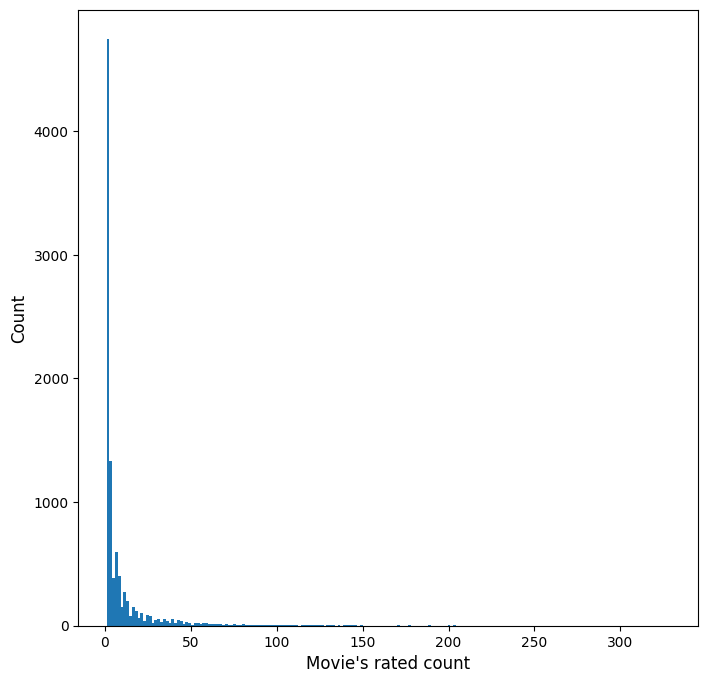

In [5]:
# 평점 데이터 정보 탐색
# 각 영화가 평가받은 횟수 탐색
movie_rate_count = rating_data.groupby('movieId')['rating'].count().values
plt.rcParams['figure.figsize'] = [8,8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

<Axes: >

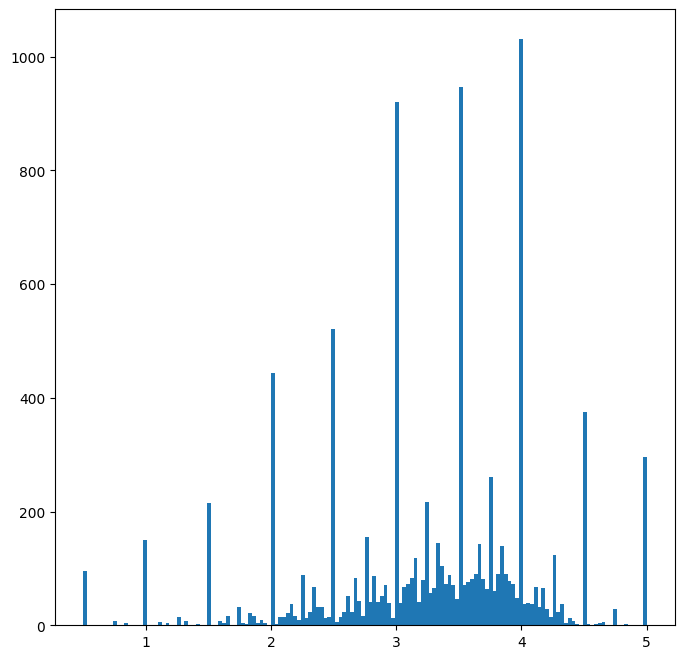

In [6]:
# 각 영화별 평균 평점 탐색
movie_grouped_rating_info = rating_data.groupby('movieId').agg(
    rated_count=('rating', 'count'),
    rating_mean=('rating', 'mean')
)
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

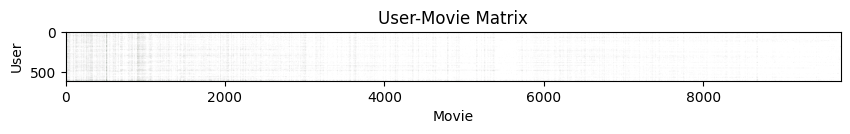

In [7]:
# 데이터 행렬로 표현
rating_table = rating_data[['userId', 'movieId', 'rating']].set_index(['userId', 'movieId']).unstack()

plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title('User-Movie Matrix')
plt.show()

In [10]:
# SVD 적용하기
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# 학습 데이터 생성
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_data[['userId', 'movieId', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델 학습
train_start = time.time()
model = SVD(n_factors=8, 
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("모델 학습 시간 : %.2f" %(train_end-train_start))

모델 학습 시간 : 0.63


In [17]:
# 영화 점수 예측할 타겟 유저 선정
target_user_id = 4
target_user_data = rating_data[rating_data['userId']==target_user_id]

# 타겟 유저의 평가 영화 히스토리 추출
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movieId']
    target_user_movie_rating_dict[movie_id] = row['rating']


# 타겟 유저가 보지 않은 영화를 테스트 데이터로 생성
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movieId']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

# 타겟 유저의 평점 점수 예측
target_user_predictions = model.test(test_data)

# 예측된 타겟 유저의 영화 별 점수 저장
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict


target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, user_id=target_user_id, user_history=target_user_movie_rating_dict)

# 예측된 점수 중 타겟 유저의 TOP 10 영화 선정
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(),
                                     key=operator.itemgetter(1), reverse=True)[:10]

# TOP 10 영화의 제목을 매칭해 출력
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movieId']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ':', predicted_rating)

Toy Story (1995) : 5
First Knight (1995) : 5
Miracle on 34th Street (1994) : 5
Three Colors: Red (Trois couleurs: Rouge) (1994) : 5
Jungle Book, The (1994) : 5
Schindler's List (1993) : 5
Mystery Science Theater 3000: The Movie (1996) : 5
All About Eve (1950) : 5
It's a Wonderful Life (1946) : 5
Herbie Rides Again (1974) : 5


In [18]:
# 예측 모델 평가
# 데이터를 학습, 테스트 용으로 분할
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_data[['userId', 'movieId', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델 학습
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)

predictions = model.test(test_data)

# 테스트 데이터의 RMSE
print(accuracy.rmse(predictions))

RMSE: 0.9053
0.9052584061827234


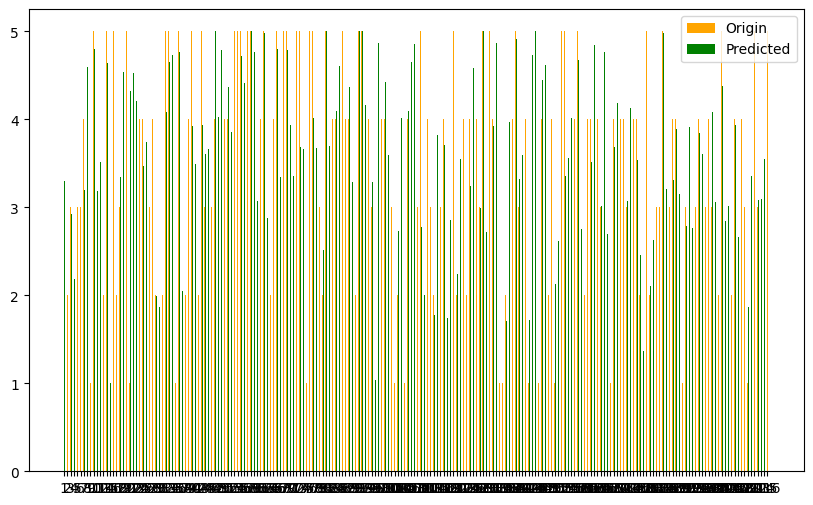

In [27]:
# 실제 평점과의 비교 시각화
# 타겟 유저 정보를 테스트 데이터로 생성
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movieId']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

# 타켓 유저의 평점 점수 예측
target_user_predictions = model.test(test_data)

# 예측된 타겟 유저의 영화 별 점수 저장
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict


# 예측된 점수 중 TOP 10 선정
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions,
                                                            user_id=target_user_id,
                                                            user_history=target_user_movie_rating_dict)

# 예측 점수와 실제 점수 영화 타이틀에 매핑
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx+1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

# 실제 점수과 예측 점수 리스트로 추출
origin = origin_rating_list
predicted = predicted_rating_list

plt.rcParams['figure.figsize'] = (10, 6)
index = np.arange(len(movie_title_list))
bar_width = 0.2

rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index+bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()